In [1]:
import lal
import lalsimulation
import numpy as np
import jax.numpy as jnp
import torch
from astropy import units as u
from phenom_p import IMRPhenomPv2
from IMRPhenomPv2 import gen_IMRPhenomPv2
import matplotlib.pyplot as plt
from conversion import (
    chirp_mass_and_mass_ratio_to_components,
    bilby_spins_to_lalsim,
)

params = {
    "text.usetex": True,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "figure.titlesize": 22,
    "axes.labelpad": 10.0,
}
plt.rcParams.update(params)

/tmp/ipykernel_285557/3938241297.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
chirp_mass = torch.tensor([30.0])
mass_ratio = torch.tensor([0.8])
mass_1, mass_2 = chirp_mass_and_mass_ratio_to_components(chirp_mass, mass_ratio)
f_ref = 20.0
sample_rate = 2048.0

In [3]:
a_1 = torch.tensor([0.5])
a_2 = torch.tensor([0.8])
tilt_1 = torch.tensor([np.pi / 3])
tilt_2 = torch.tensor([np.pi / 2])
phi_12 = torch.tensor([np.pi / 4])
phi_jl = torch.tensor([np.pi / 6])
distance = torch.tensor([500.0])
theta_jn = torch.tensor([np.pi / 4])
phase = torch.tensor([7 * np.pi / 4])

In [4]:
inclination, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z = bilby_spins_to_lalsim(
    theta_jn,
    phi_jl,
    tilt_1,
    tilt_2,
    phi_12,
    a_1,
    a_2,
    mass_1,
    mass_2,
    f_ref,
    phase,
)

In [5]:
params = dict(
    m1=mass_1.item() * lal.MSUN_SI,
    m2=mass_2.item() * lal.MSUN_SI,
    S1x=chi1x.item(),
    S1y=chi1y.item(),
    S1z=chi1z.item(),
    S2x=chi2x.item(),
    S2y=chi2y.item(),
    S2z=chi2z.item(),
    distance=(distance.item() * u.Mpc).to("m").value,
    inclination=inclination.item(),
    phiRef=phase.item(),
    longAscNodes=0.0,
    eccentricity=0.0,
    meanPerAno=0.0,
    deltaF=1.0 / sample_rate,
    f_min=10.0,
    f_ref=f_ref,
    f_max=300,
    approximant=lalsimulation.IMRPhenomPv2,
    LALpars=lal.CreateDict(),
)
hp_lal, hc_lal = lalsimulation.SimInspiralChooseFDWaveform(**params)

In [6]:
lal_freqs = np.array(
    [hp_lal.f0 + ii * hp_lal.deltaF for ii in range(len(hp_lal.data.data))]
)

theta_ripple = jnp.array(
    [
        mass_1.item(),
        mass_2.item(),
        chi1x.item(),
        chi1y.item(),
        chi1z.item(),
        chi2x.item(),
        chi2y.item(),
        chi2z.item(),
        distance.item(),
        0,
        phase.item(),
        inclination.item(),
    ]
)

lal_mask = (lal_freqs > params["f_min"]) & (lal_freqs < params["f_max"])

lal_freqs = lal_freqs[lal_mask]
ml4gw_freqs = torch.tensor(lal_freqs, dtype=torch.float32)
ripple_freqs = jnp.array(lal_freqs)

hc_ml4gw, hp_ml4gw = IMRPhenomPv2()(
    ml4gw_freqs,
    chirp_mass,
    mass_ratio,
    chi1x,
    chi1y,
    chi1z,
    chi2x,
    chi2y,
    chi2z,
    distance,
    phase,
    inclination,
    f_ref,
    torch.tensor([0.0]),
)

hp_ripple, hc_ripple = gen_IMRPhenomPv2(ripple_freqs, theta_ripple, f_ref)

hp_ml4gw = hp_ml4gw[0].detach().numpy()
hc_ml4gw = hc_ml4gw[0].detach().numpy()

hp_lal_data = hp_lal.data.data[lal_mask]
hc_lal_data = hc_lal.data.data[lal_mask]

In [7]:
chirp_mass, mass_ratio, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, distance, phase, inclination

(tensor([30.]),
 tensor([0.8000]),
 tensor([-0.3501]),
 tensor([-0.2548]),
 tensor([0.2500]),
 tensor([-0.1244]),
 tensor([-0.7903]),
 tensor([-2.3842e-08]),
 tensor([500.]),
 tensor([5.4978]),
 tensor([0.6888]))

In [8]:
diff_lal_ml4gw = np.maximum(
    np.abs(hp_lal_data - hp_ml4gw), np.abs(hc_lal_data - hc_ml4gw)
)
diff_lal_ripple = np.maximum(
    np.abs(hp_lal_data - hp_ripple), np.abs(hc_lal_data - hc_ripple)
)
diff_ml4gw_ripple = np.maximum(
    np.abs(hp_ml4gw - hp_ripple), np.abs(hc_ml4gw - hc_ripple)
)

# **Ripple vs LAL**

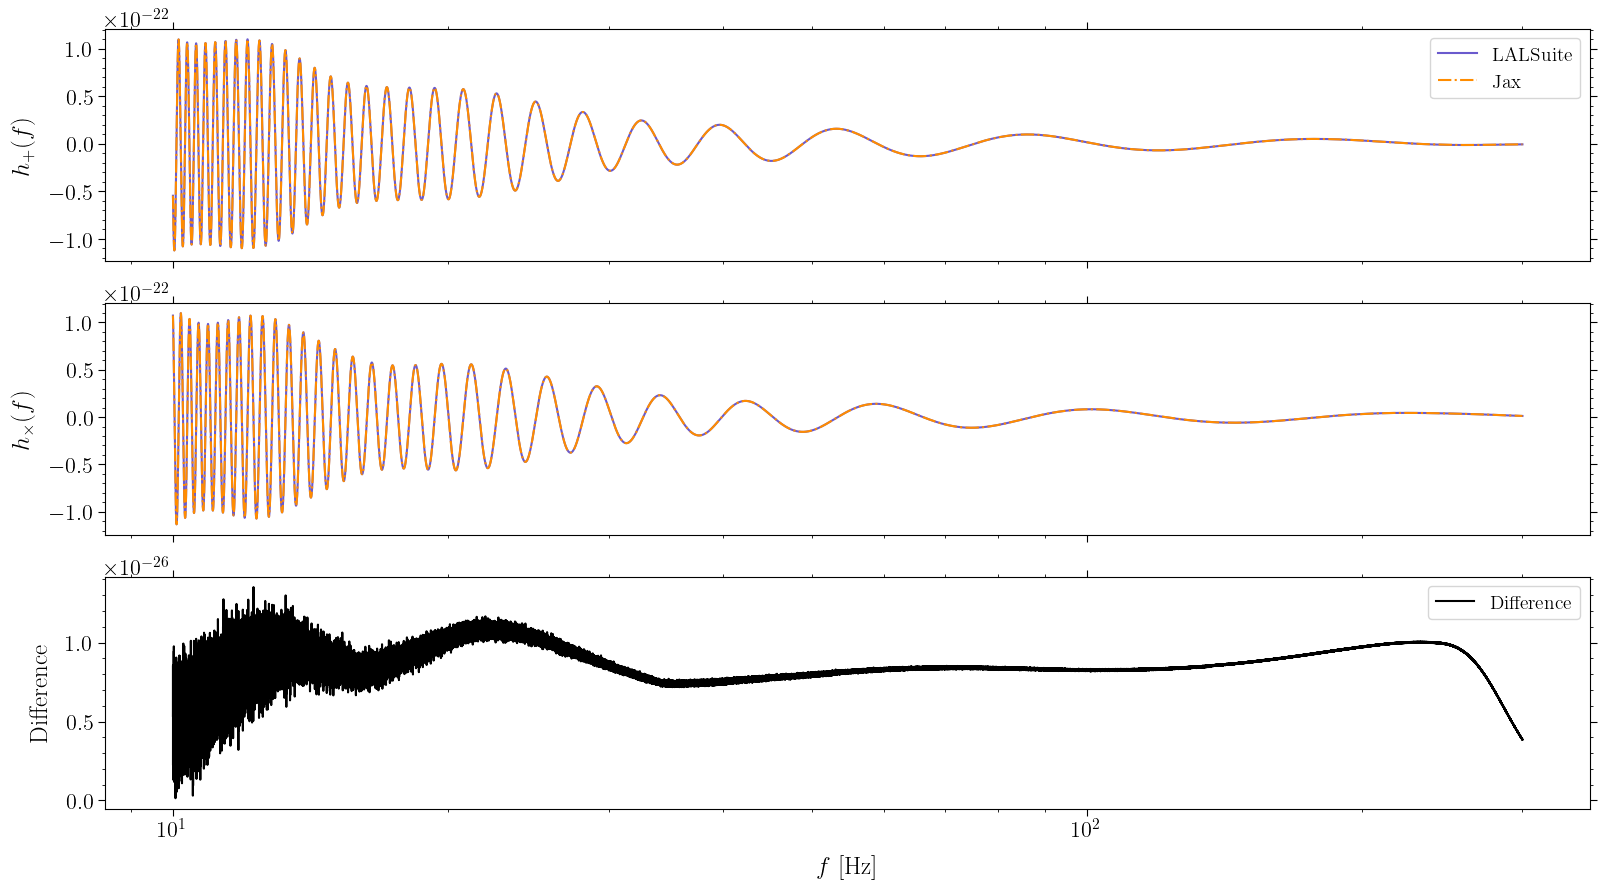

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(lal_freqs, hp_lal_data.real, label="LALSuite", color="slateblue")
ax[0].plot(lal_freqs, hp_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(lal_freqs, hc_lal_data.real, label="LALSuite", color="slateblue")
ax[1].plot(lal_freqs, hc_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(lal_freqs, diff_lal_ripple, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **ML4GW vs LAL**

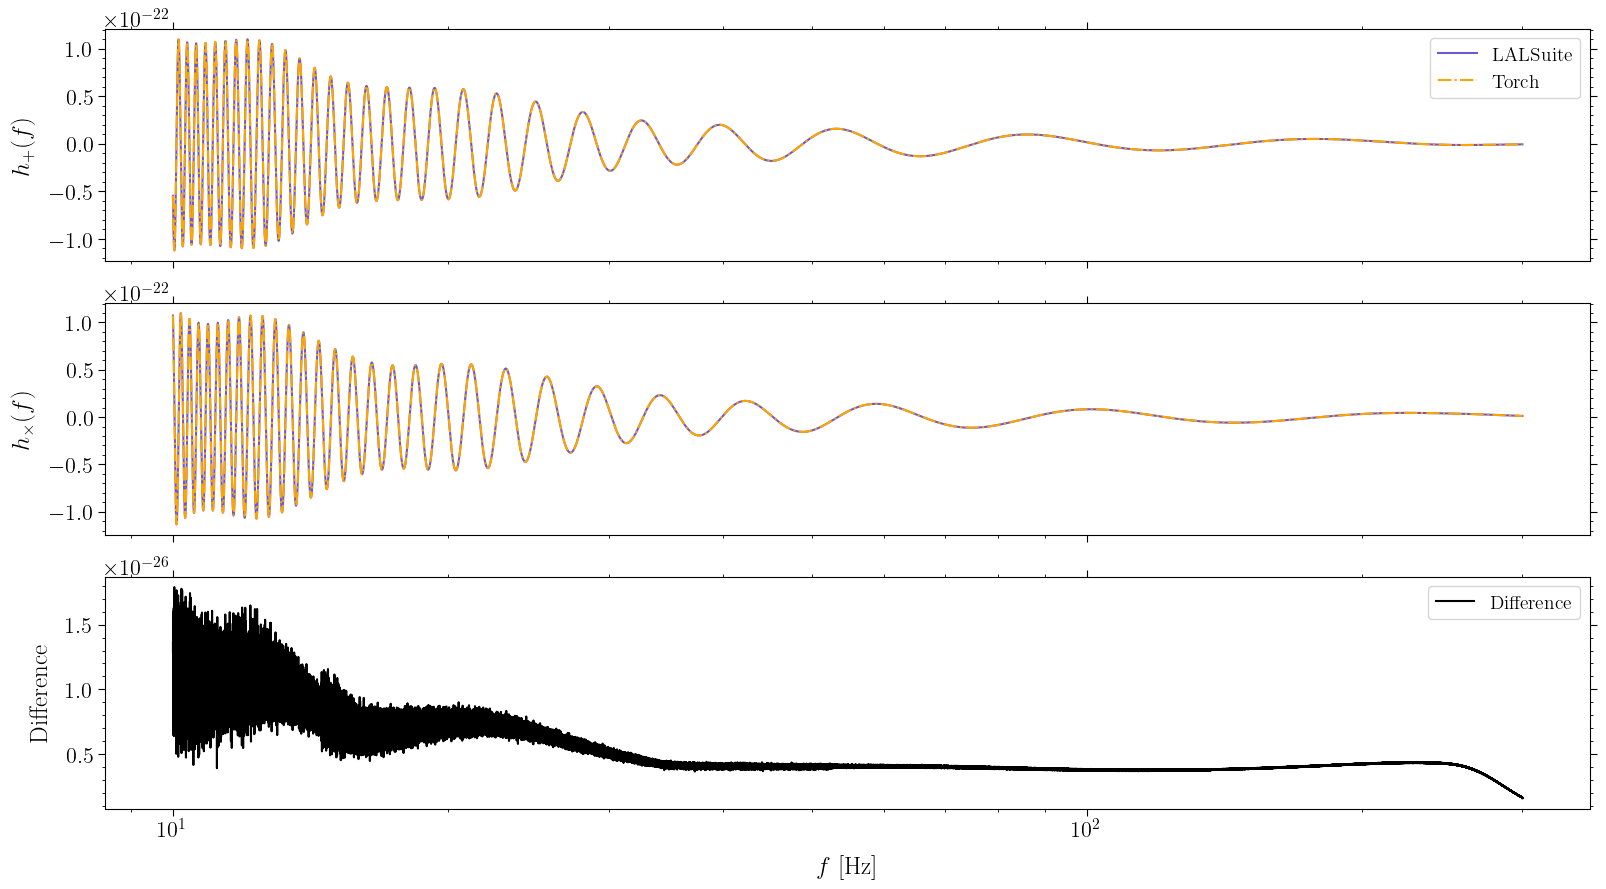

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(lal_freqs, hp_lal_data.real, label="LALSuite", color="slateblue")
ax[0].plot(lal_freqs, hp_ml4gw.real, label="Torch", color="orange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(lal_freqs, hc_lal_data.real, label="LALSuite", color="slateblue")
ax[1].plot(lal_freqs, hc_ml4gw.real, label="Torch", color="orange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(lal_freqs, diff_lal_ml4gw, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **ML4GW vs Ripple**

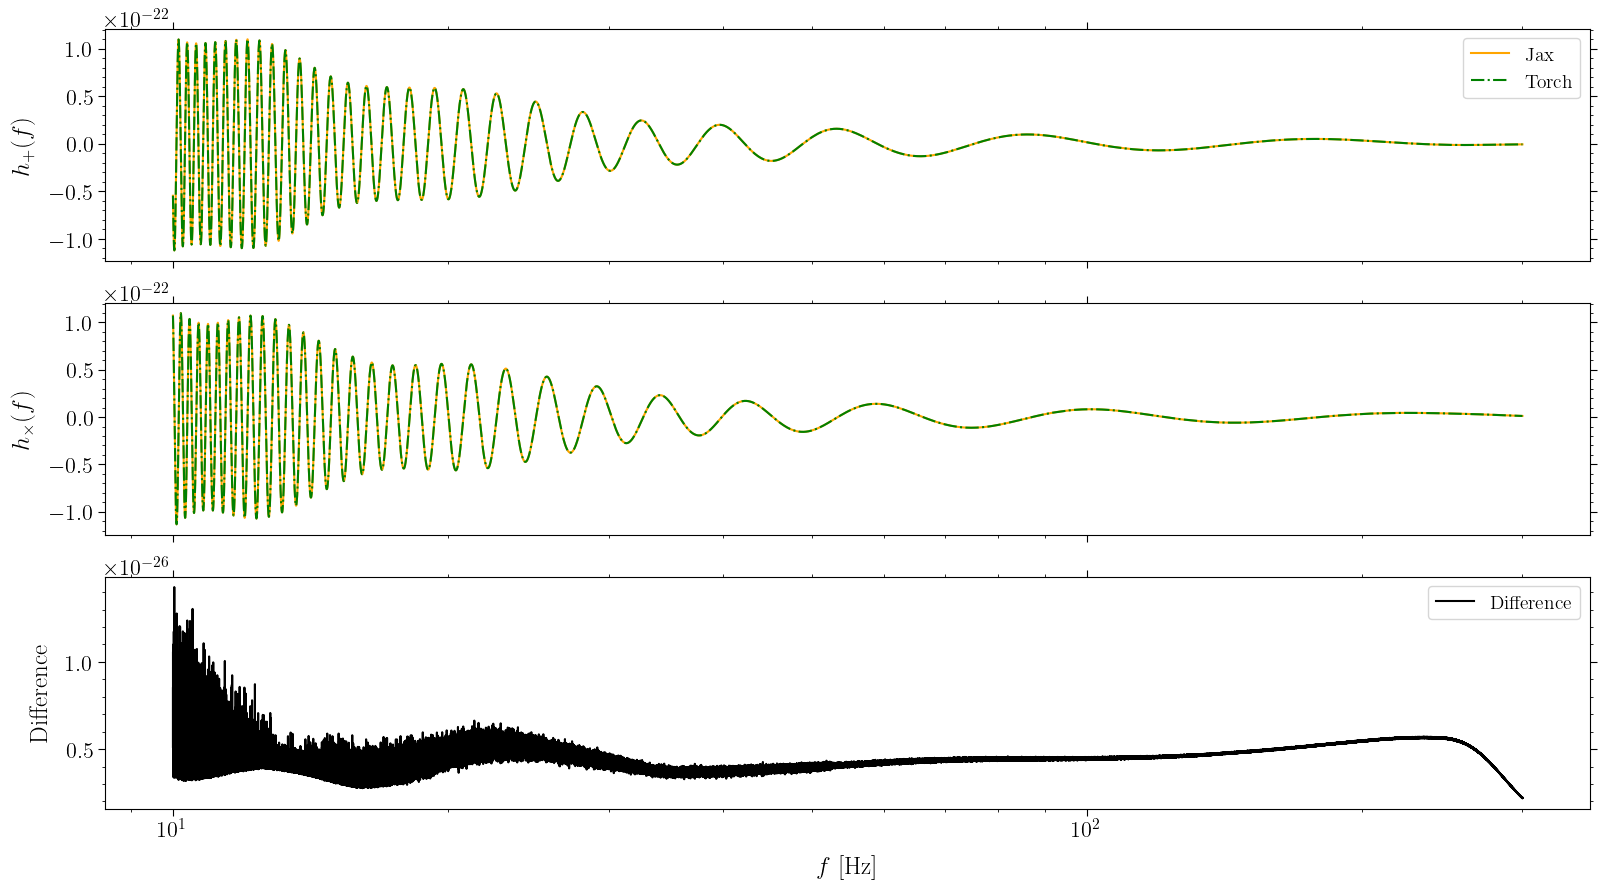

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(lal_freqs, hp_ripple.real, label="Jax", color="orange")
ax[0].plot(lal_freqs, hp_ml4gw.real, label="Torch", color="green", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(lal_freqs, hc_ripple.real, label="Jax", color="orange")
ax[1].plot(lal_freqs, hc_ml4gw.real, label="Torch", color="green", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(lal_freqs, diff_ml4gw_ripple, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

In [18]:
# ripple_amp = np.load("ripple_amp.npy") + 1e-24
# ml4gw_amp = np.load("ml4gw_amp.npy") + 1e-24
# plt.figure(dpi=300)
# plt.plot(lal_freqs, ripple_amp, label="JAX")
# plt.plot(lal_freqs, ml4gw_amp[0], label="Torch", linestyle="--")
# plt.legend()
# plt.yscale("log")
# plt.xscale("log")

In [19]:
# ripple_phase = np.load("ripple_phase.npy") + 100
# ml4gw_phase = np.load("ml4gw_phase.npy") + 100
# plt.figure(dpi=300)
# plt.plot(ripple_phase, label="JAX")
# plt.plot(ml4gw_phase[0], label="Torch", ls="--")
# # plt.plot(np.abs(jax_phase - torch_phase[0]), label="Difference")
# plt.legend()
# plt.yscale("log")